<a href="https://colab.research.google.com/github/HadilGhaith/Prediction-of-Product-Sales/blob/main/Adult_Income.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn import set_config
set_config(transform_output='pandas')
# modeling
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance


In [3]:
#### this function is only for classification not inclued ploting vs cnumeric target
"""UNIVARIATE PLOTTING FUNCTIONS FOR EDA"""
# Add the print statements to the function
def explore_categorical(df, x, fillna = True, placeholder = 'MISSING',
                        figsize = (6,4), order = None):
  """Creates a seaborn countplot with the option to temporarily fill missing values
  Prints statements about null values, cardinality, and checks for
  constant/quasi-constant features.
  Source:{PASTE IN FINAL LESSON LINK}
  """
  # Make a copy of the dataframe and fillna
  temp_df = df.copy()
  # Before filling nulls, save null value counts and percent for printing
  null_count = temp_df[x].isna().sum()
  null_perc = null_count/len(temp_df)* 100
  # fillna with placeholder
  if fillna == True:
    temp_df[x] = temp_df[x].fillna(placeholder)
  # Create figure with desired figsize
  fig, ax = plt.subplots(figsize=figsize)
  # Plotting a count plot
  sns.countplot(data=temp_df, x=x, ax=ax, order=order)
  # Rotate Tick Labels for long names
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
  # Add a title with the feature name included
  ax.set_title(f"Column: {x}", fontweight='bold')

  # Fix layout and show plot (before print statements)
  fig.tight_layout()
  plt.show()

  # Print null value info
  print(f"- NaN's Found: {null_count} ({round(null_perc,2)}%)")
  # Print cardinality info
  nunique = temp_df[x].nunique()
  print(f"- Unique Values: {nunique}")
  # First find value counts of feature
  val_counts = temp_df[x].value_counts(dropna=False)
  # Define the most common value
  most_common_val = val_counts.index[0]
  # Define the frequency of the most common value
  freq = val_counts.values[0]
  # Calculate the percentage of the most common value
  perc_most_common = freq / len(temp_df) * 100
  # Print the results
  print(f"- Most common value: '{most_common_val}' occurs {freq} times ({round(perc_most_common,2)}%)")
  # print message if quasi-constant or constant (most common val more than 98% of data)
  if perc_most_common > 98:
    print(f"\n- [!] Warning: '{x}' is a constant or quasi-constant feature and should be dropped.")
  else:
    print("- Not constant or quasi-constant.")
  return fig, ax


# TO DO: add the new print statements from explore_categorical
def explore_numeric(df, x, figsize=(6,5) ):
  """Creates a seaborn histplot and boxplot with a share x-axis,
  Prints statements about null values, cardinality, and checks for
  constant/quasi-constant features.
  Source:{PASTE IN FINAL LESSON LINK}
  """

  ## Save null value counts and percent for printing
  null_count = df[x].isna().sum()
  null_perc = null_count/len(df)* 100


  ## Making our figure with gridspec for subplots
  gridspec = {'height_ratios':[0.7,0.3]}
  fig, axes = plt.subplots(nrows=2, figsize=figsize,
                           sharex=True, gridspec_kw=gridspec)
  # Histogram on Top
  sns.histplot(data=df, x=x, ax=axes[0])

  # Boxplot on Bottom
  sns.boxplot(data=df, x=x, ax=axes[1])

  ## Adding a title
  axes[0].set_title(f"Column: {x}", fontweight='bold')

  ## Adjusting subplots to best fill Figure
  fig.tight_layout()

  # Ensure plot is shown before message
  plt.show()


  # Print null value info
  print(f"- NaN's Found: {null_count} ({round(null_perc,2)}%)")
  # Print cardinality info
  nunique = df[x].nunique()
  print(f"- Unique Values: {nunique}")


  # Get the most most common value, its count as # and as %
  most_common_val_count = df[x].value_counts(dropna=False).head(1)
  most_common_val = most_common_val_count.index[0]
  freq = most_common_val_count.values[0]
  perc_most_common = freq / len(df) * 100

  print(f"- Most common value: '{most_common_val}' occurs {freq} times ({round(perc_most_common,2)}%)")

  # print message if quasi-constant or constant (most common val more than 98% of data)
  if perc_most_common > 98:
    print(f"\n- [!] Warning: '{x}' is a constant or quasi-constant feature and should be dropped.")
  else:
    print("- Not constant or quasi-constant.")
  return fig, axes

# plot categorical vs target
def plot_categorical_vs_target(df, x, y, figsize=(6,4),
                            fillna = True, placeholder = 'MISSING',
                            order = None):
  # Make a copy of the dataframe and fillna
  temp_df = df.copy()
  # fillna with placeholder
  if fillna == True:
    temp_df[x] = temp_df[x].fillna(placeholder)
  # or drop nulls prevent unwanted 'nan' group in stripplot
  else:
    temp_df = temp_df.dropna(subset=[x])
  # Create the figure and subplots
  fig, ax = plt.subplots(figsize=figsize)
  ax = sns.histplot(data=temp_df, hue=y, x=x, stat='percent',  multiple='fill')
  # Rotate xlabels
  ax.set_xticks(ax.get_xticks()) # Added this to prevent a bug
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
  # Add a title
  ax.set_title(f"{x} vs. {y}")
  fig.tight_layout()
  return fig, ax

# plot numeric vss target
def plot_numeric_vs_target(df, x, y, figsize=(6,4),
                           estimator='mean',
                           errorbar='ci',sorted=False,ascending=False,
                           **kwargs): # kwargs for sns.regplot

  nulls = df[[x,y]].isna().sum()
  if nulls.sum()>0:
    print(f"- Excluding {nulls.sum()} NaN's")
    # print(nulls)
    temp_df = df.dropna(subset=[x,y,])
  else:
    temp_df = df
  # Create the figure
  fig, ax = plt.subplots(figsize=figsize)
  # Sort the groups by median/mean
  if sorted == True:

      if estimator == 'median':
        group_vals = temp_df.groupby(y)[x].median()
      elif estimator =='mean':
        group_vals = temp_df.groupby(y)[x].mean()

      ## Sort values
      group_vals = group_vals.sort_values(ascending=ascending)
      order = group_vals.index

  else:
      # Set order to None if not calcualted
      order = None

     # Left Subplot (barplot)
  sns.barplot(data=temp_df, x=y, y=x, order=order,  estimator=estimator,
                errorbar=errorbar, ax=ax, **kwargs)

    # Add title
  ax.set_title(f"{x} vs. {y}")

    # rotate xaxis labels
  ax.set_xticks(ax.get_xticks())
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


  # Final Adjustments & return
  fig.tight_layout()
  fig.show()
  return fig, ax

In [4]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
def classification_metrics(y_true, y_pred, label="",
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False):
  # Get the classification report
  report = classification_report(y_true, y_pred)
  ## Print header and report
  header = "-"*70
  print(header, f" Classification Metrics: {label}", header, sep='\n')
  print(report)
  ## CONFUSION MATRICES SUBPLOTS
  fig, axes = plt.subplots(ncols=2, figsize=figsize)
  # create a confusion matrix  of raw counts
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=None, cmap='gist_gray', colorbar=colorbar,
                ax = axes[0],);
  axes[0].set_title("Raw Counts")
  # create a confusion matrix with the test data
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=normalize, cmap=cmap, colorbar=colorbar,
                ax = axes[1]);
  axes[1].set_title("Normalized Confusion Matrix")
  # Adjust layout and show figure
  fig.tight_layout()
  plt.show()
  # Return dictionary of classification_report
  if output_dict==True:
    report_dict = classification_report(y_true, y_pred, output_dict=True)
    return report_dict



def evaluate_classification(model, X_train, y_train, X_test, y_test,
                         figsize=(6,4), normalize='true', output_dict = False,
                            cmap_train='Blues', cmap_test="Reds",colorbar=False):
  # Get predictions for training data
  y_train_pred = model.predict(X_train)
  # Call the helper function to obtain regression metrics for training data
  results_train = classification_metrics(y_train, y_train_pred, #verbose = verbose,
                                     output_dict=True, figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_train,
                                     label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = model.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = classification_metrics(y_test, y_test_pred, #verbose = verbose,
                                  output_dict=True,figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_test,
                                    label='Test Data' )
  if output_dict == True:
    # Store results in a dataframe if ouput_frame is True
    results_dict = {'train':results_train,
                    'test': results_test}
    return results_dict



In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
path = '/content/drive/MyDrive/CodingDojo/03-DataEnrichment/Week09/Data/adult.csv'
df = pd.read_csv(path)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48842 non-null  int64 
 1   workclass        48842 non-null  object
 2   fnlwgt           48842 non-null  int64 
 3   education        48842 non-null  object
 4   educational-num  48842 non-null  int64 
 5   marital-status   48842 non-null  object
 6   occupation       48842 non-null  object
 7   relationship     48842 non-null  object
 8   race             48842 non-null  object
 9   gender           48842 non-null  object
 10  capital-gain     48842 non-null  int64 
 11  capital-loss     48842 non-null  int64 
 12  hours-per-week   48842 non-null  int64 
 13  native-country   48842 non-null  object
 14  income           48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


- our target is know if the income more than, or less than 50k.
- each row reresent an informatiom of a person.
- there are 15 features.
- there are 48842 rows.
- i will reduse the  dimensionality there is some features gives same information and otheres can we add to eachother(capital gain and loss).


# Data Cleaning

In [7]:
# check duplicated rows
df.duplicated().sum()

52

In [8]:
# drop duplucated
df = df.drop_duplicates()
df.duplicated().sum()

0

In [9]:
# cheack null values
df.isna().sum()

age                0
workclass          0
fnlwgt             0
education          0
educational-num    0
marital-status     0
occupation         0
relationship       0
race               0
gender             0
capital-gain       0
capital-loss       0
hours-per-week     0
native-country     0
income             0
dtype: int64

In [10]:
# check categorical columns
# define a variabel
cat_cols = df.select_dtypes('object').columns
# loop to check the value counts for categorical columnns
for col in cat_cols:
  print(f'The Value Counts of: {col}\n')
  print(df[col].value_counts())

The Value Counts of: workclass

workclass
Private             33860
Self-emp-not-inc     3861
Local-gov            3136
?                    2795
State-gov            1981
Self-emp-inc         1694
Federal-gov          1432
Without-pay            21
Never-worked           10
Name: count, dtype: int64
The Value Counts of: education

education
HS-grad         15770
Some-college    10863
Bachelors        8013
Masters          2656
Assoc-voc        2060
11th             1812
Assoc-acdm       1601
10th             1389
7th-8th           954
Prof-school       834
9th               756
12th              655
Doctorate         594
5th-6th           507
1st-4th           245
Preschool          81
Name: count, dtype: int64
The Value Counts of: marital-status

marital-status
Married-civ-spouse       22366
Never-married            16082
Divorced                  6630
Separated                 1530
Widowed                   1518
Married-spouse-absent      627
Married-AF-spouse           37
Name: cou

In [11]:
# # i will replace ? with Without-pay both have cose income avarge
# 1 workclass column
df['workclass'] = df['workclass'].replace('?', 'Without-pay')
df['workclass'].value_counts(dropna=False)

workclass
Private             33860
Self-emp-not-inc     3861
Local-gov            3136
Without-pay          2816
State-gov            1981
Self-emp-inc         1694
Federal-gov          1432
Never-worked           10
Name: count, dtype: int64

In [12]:
# education column (i will replace the / value with Machine-op-inspct becuse both of values are almost close with thir counst and their income avarge )
df['occupation'] = df['occupation'].replace('?', 'Machine-op-inspct')
df['occupation'].value_counts(dropna=False)

occupation
Prof-specialty       6165
Craft-repair         6102
Exec-managerial      6082
Machine-op-inspct    5822
Adm-clerical         5606
Sales                5501
Other-service        4919
Transport-moving     2355
Handlers-cleaners    2071
Farming-fishing      1485
Tech-support         1445
Protective-serv       982
Priv-house-serv       240
Armed-Forces           15
Name: count, dtype: int64

In [13]:
# i will replace ? with most frequint country and also both of value have almost same aincome avarage
df['native-country'] = df['native-country'].replace('?', 'United-States')
df['native-country'].value_counts(dropna=False)

native-country
United-States                 44648
Mexico                          943
Philippines                     294
Germany                         206
Puerto-Rico                     184
Canada                          182
El-Salvador                     155
India                           151
Cuba                            138
England                         127
China                           122
South                           115
Jamaica                         106
Italy                           105
Dominican-Republic              103
Japan                            92
Poland                           87
Vietnam                          86
Guatemala                        86
Columbia                         85
Haiti                            75
Portugal                         67
Taiwan                           65
Iran                             59
Greece                           49
Nicaragua                        49
Peru                             46
Ecuador      

- for categorical columns after visualize them will decide what will remain and what will dropp.

In [14]:
# check numerical columns
# define a vriabel
num_cols = df.select_dtypes('number').columns
print(f'Numarical columns are: {num_cols}')
# check the statistical values for numerical cols
df.describe()

Numarical columns are: Index(['age', 'fnlwgt', 'educational-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object')


,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week
count,48790.000000,4.879000e+04,48790.000000,48790.000000,48790.000000,48790.000000
mean,38.652798,1.896690e+05,10.078807,1080.217688,87.595573,40.425886
std,13.708493,1.056172e+05,2.570046,7455.905921,403.209129,12.392729
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.175550e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.781385e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.376062e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


-  there is no problem with the number in numerical columns.

In [15]:
# check the value couns of educational -num
df['educational-num'].value_counts(ascending=True)

educational-num
1        81
2       245
3       507
16      594
8       655
5       756
15      834
4       954
6      1389
12     1601
7      1812
11     2060
14     2656
13     8013
10    10863
9     15770
Name: count, dtype: int64

In [16]:
## I WILL REPLACE THE VALUES IN EDUCATION COLES AND MAKE THEM INTO ONLY 6 DIFFRENT VALUE
for val in df['education']:
  if val == '1st-4th':

    df['education'] = df['education'].replace('1st-4th','compulsory')
  elif val == '5th-6th':
    df['education'] = df['education'].replace('5th-6th','compulsory')
  elif val == '7th-8th':
     df['education'] = df['education'].replace('7th-8th','compulsory')
  elif val == '9th':
     df['education'] = df['education'].replace('9th','compulsory')
  elif val == '10th':
     df['education'] = df['education'].replace('10th','compulsory')
  elif val == '11th':
     df['education'] = df['education'].replace('11th','compulsory')
  elif val == '12th':
     df['education'] = df['education'].replace('12th','compulsory')
  elif val == 'Preschool':
     df['education'] = df['education'].replace('Preschool','compulsory')
  elif val == "Some-college":
     df['education'] = df['education'].replace('Some-college', 'Bachelors')
  elif val == "Assoc-acdm":
     df['education'] = df['education'].replace("Assoc-acdm", "Associate")
  elif val == "Assoc-voc":
      df['education'] = df['education'].replace("Assoc-voc", "Associate")
  else:
    df['education'] = df['education']

In [17]:
df['education'].value_counts()

education
Bachelors      18876
HS-grad        15770
compulsory      6399
Associate       3661
Masters         2656
Prof-school      834
Doctorate        594
Name: count, dtype: int64

In [18]:
df['education'].nunique()

7

In [19]:
type(df['age'])

pandas.core.series.Series

In [20]:
#  INCOME COLUMNS
incom_map = {'<=50K':0, '>50K':1}
df['income'] = df['income'].replace('<=50K', 0)
df['income'] = df['income'].replace('>50K', 1)
df['income'].value_counts()

income
0    37109
1    11681
Name: count, dtype: int64

# Data Visualizing

In [21]:
#  define target
y = 'income'

<Axes: >

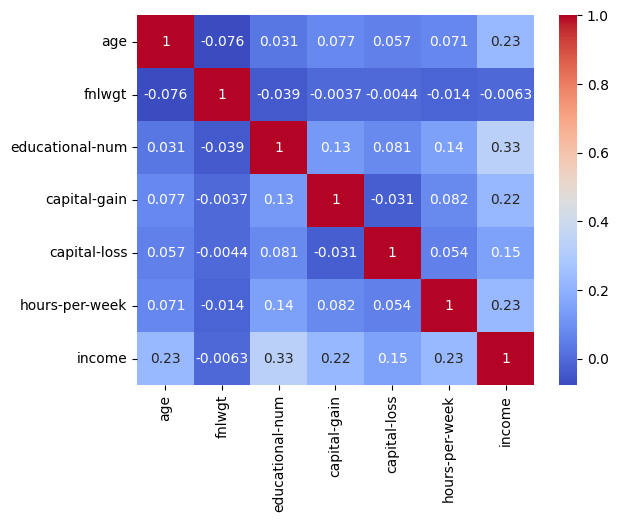

In [22]:
#corrolation between numeic features
corr = df.corr(numeric_only=True)
corr.round(2)
# heatmap
sns.heatmap(corr, cmap = 'coolwarm', annot=True)

### Example: {educational-num}



- age: age of person .
  
  

In [23]:
# # Confirming the dtype to select correct EDA function
feature = "educational-num"
df[feature].dtype

dtype('int64')

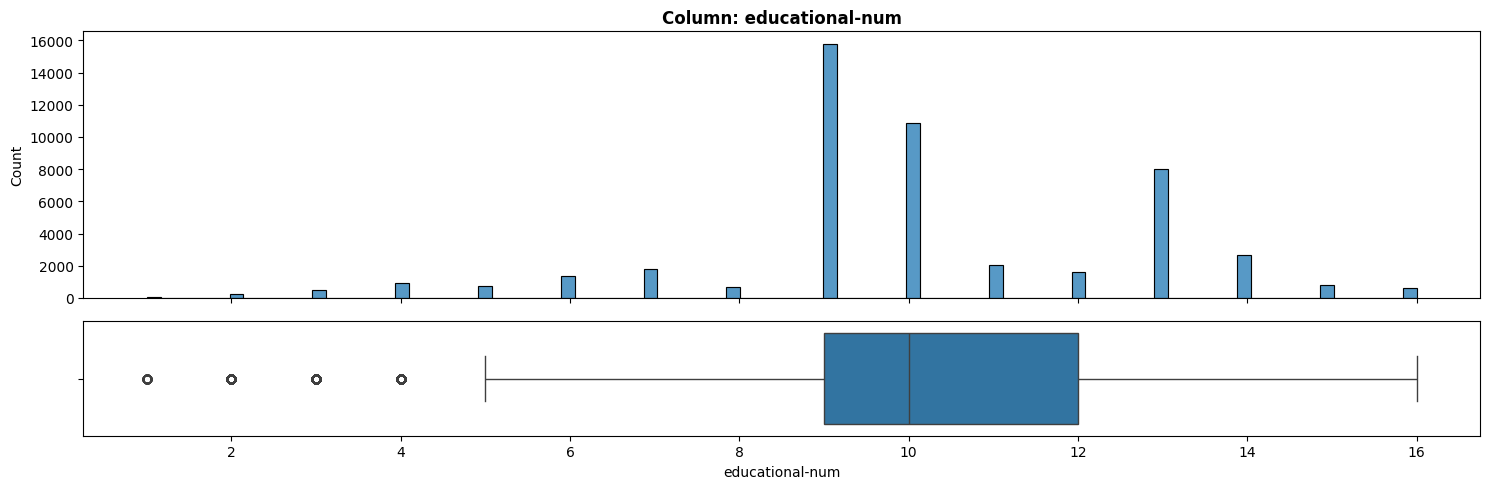

- NaN's Found: 0 (0.0%)
- Unique Values: 16
- Most common value: '9' occurs 15770 times (32.32%)
- Not constant or quasi-constant.


In [25]:
# run the appropriate explore function (based on feature's dtype)
explore_numeric(df, feature, figsize=(15,5));

**Feature Observations**

1. What type of feature is it? (Categorical (nominal), ordinal, numeric)
  - numeric

2. How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? if impute, with what?)
  -
  - 0

3. Is the feature constant or quasi-constant?
  - it not

4. What is the cardinality? Is it high?
  - not categorical
  -

5. Would we know this BEFORE the target is determined?
  - ...

6. Is there a business case/understanding reason to exclude based on our business case?
  - no



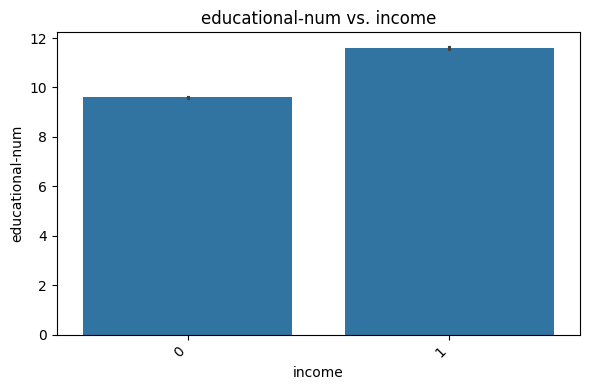

In [26]:
# Run the appropriate feature vs. target function (based on dtype)
plot_numeric_vs_target(df,x=feature, y=y);

- Feature vs. Target Observations:
  - Based on your business understanding, would you expect this feature to be a predictor of the target?
    - yes ,
  - Does this feature appear to be a predictor of the target?
    - it seems like people with higher eduacation  have more income than  people with lower eduacation.


___

### Example: {age}



- age: age of person .
  
  

In [65]:
# # Confirming the dtype to select correct EDA function
feature = "age"
df[feature].dtype

dtype('int64')

<ipython-input-4-106c1043cd27>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


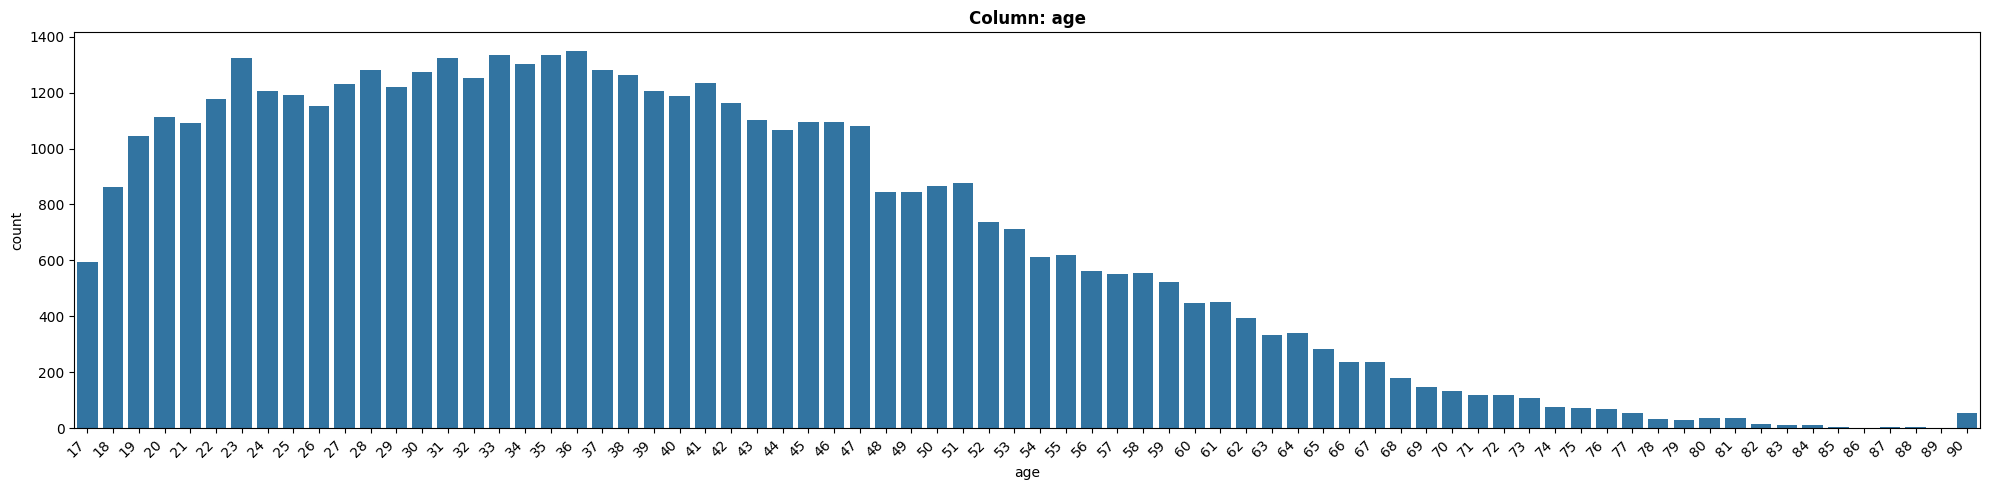

- NaN's Found: 0 (0.0%)
- Unique Values: 74
- Most common value: '36' occurs 1348 times (2.76%)
- Not constant or quasi-constant.


In [66]:
# run the appropriate explore function (based on feature's dtype)
explore_categorical(df, feature, figsize=(20,5));

**Feature Observations**

1. What type of feature is it? (Categorical (nominal), ordinal, numeric)
  - numeric

2. How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? if impute, with what?)
  
  - 0

3. Is the feature constant or quasi-constant?
  - it not

4. What is the cardinality? Is it high?
  - not categorical
  -

5. Would we know this BEFORE the target is determined?
  - ...

6. Is there a business case/understanding reason to exclude based on our business case?
  - no



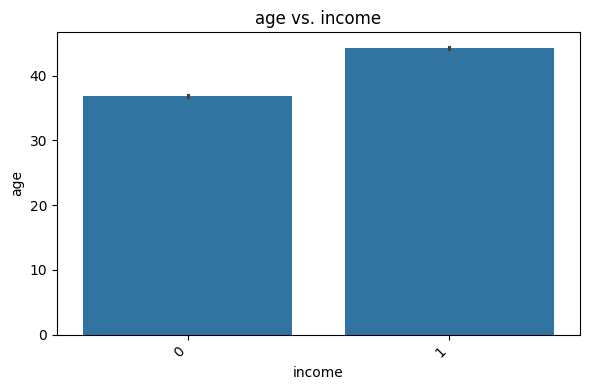

In [67]:
# Run the appropriate feature vs. target function (based on dtype)
plot_numeric_vs_target(df,x=feature, y=y);

- Feature vs. Target Observations:
  - Based on your business understanding, would you expect this feature to be a predictor of the target?
    - maybe
  - Does this feature appear to be a predictor of the target?
    - it seems like people older than 38 have more income than people with age avarage less than 38.


___

### Example: {workclass}

> Indented block



- workclass:a general term to represent the employment status of an person.
  - Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
  
  

In [68]:
# # Confirming the dtype to select correct EDA function
feature = "workclass"
df[feature].dtype

dtype('O')

<ipython-input-4-106c1043cd27>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


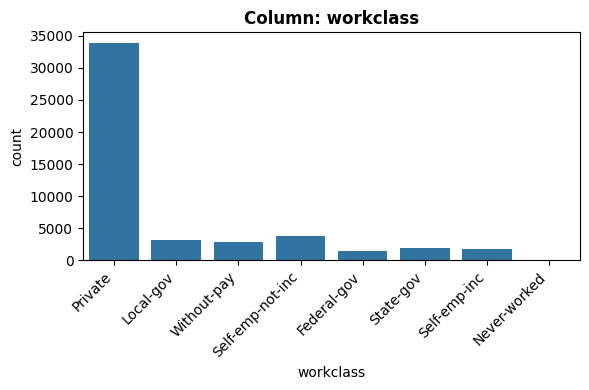

- NaN's Found: 0 (0.0%)
- Unique Values: 8
- Most common value: 'Private' occurs 33860 times (69.4%)
- Not constant or quasi-constant.


In [69]:
# run the appropriate explore function (based on feature's dtype)
explore_categorical(df, feature);

**Feature Observations**

1. What type of feature is it? (Categorical (nominal), ordinal, numeric)
  - nominal

2. How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? if impute, with what?)
  
  - 0

3. Is the feature constant or quasi-constant?
  - its not

4. What is the cardinality? Is it high?
  - 9 unique value
  - closer to high cardinality

5. Would we know this BEFORE the target is determined?
  - ...

6. Is there a business case/understanding reason to exclude based on our business case?
  - no



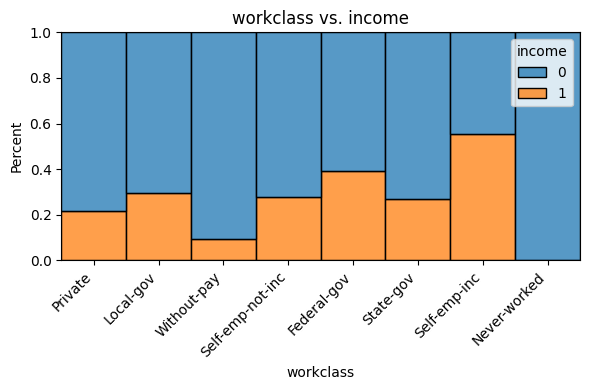

In [70]:
# Run the appropriate feature vs. target function (based on dtype)
plot_categorical_vs_target(df,x=feature, y=y);

- Feature vs. Target Observations:
  - Based on your business understanding, would you expect this feature to be a predictor of the target?
    - yes there is a a relation between the work class and the income for example peopel who never worked have income less than 50 k and there is non with income more than 50k, but who work as self-emp-inc there ia around 60%of them their income more than 50k
- Does this feature appear to be a predictor of the target?
    -yes it is


___

### Example: {fnlwgt}





- fnlwgt:number of people the census believes the entry represents .
  
  

In [71]:
# # Confirming the dtype to select correct EDA function
feature = "fnlwgt"
df[feature].dtype

dtype('int64')

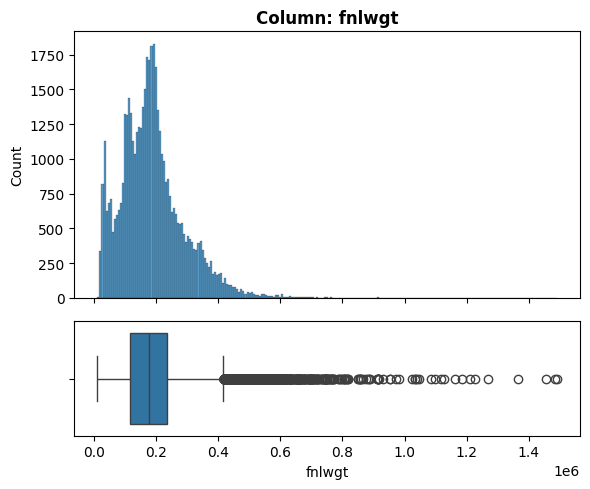

- NaN's Found: 0 (0.0%)
- Unique Values: 28523
- Most common value: '203488' occurs 21 times (0.04%)
- Not constant or quasi-constant.


In [72]:
# run the appropriate explore function (based on feature's dtype)
explore_numeric(df, feature);

**Feature Observations**

1. What type of feature is it? (Categorical (nominal), ordinal, numeric)
  - numeric

2. How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? if impute, with what?)
  - 0
  -

3. Is the feature constant or quasi-constant?
  - its not

4. What is the cardinality? Is it high?
  - its numeric
  -

5. Would we know this BEFORE the target is determined?
  - ...

6. Is there a business case/understanding reason to exclude based on our business case?
  - no



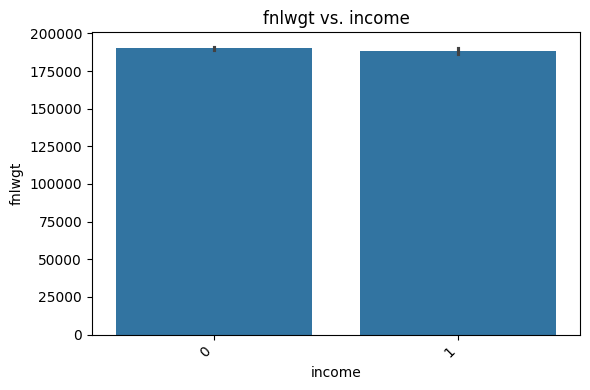

In [73]:
# Run the appropriate feature vs. target function (based on dtype)
plot_numeric_vs_target(df,x=feature, y=y);

- Feature vs. Target Observations:
  - Based on your business understanding, would you expect this feature to be a predictor of the target?
    - its not a predictor for the target
  - Does this feature appear to be a predictor of the target?
    - no, and i will drop it befor preprocessing data


___

### Example: {education}




- education:the highest level of education achieved by an person .
  - Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool
  

In [74]:
# # Confirming the dtype to select correct EDA function
feature = "education"
df[feature].dtype

dtype('O')

<ipython-input-4-106c1043cd27>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


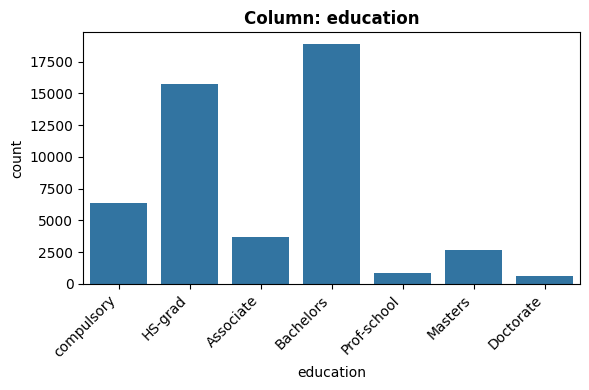

- NaN's Found: 0 (0.0%)
- Unique Values: 7
- Most common value: 'Bachelors' occurs 18876 times (38.69%)
- Not constant or quasi-constant.


In [75]:
# run the appropriate explore function (based on feature's dtype)
explore_categorical(df, feature);

**Feature Observations**

1. What type of feature is it? (Categorical (nominal), ordinal, numeric)
  - ordinal

2. How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? if impute, with what?)
  - 0
  -

3. Is the feature constant or quasi-constant?
  - its not

4. What is the cardinality? Is it high?
  - unique value= 16
  - high cardinalty
  
  5. Would we know this BEFORE the target is determined?
  - ...

6. Is there a business case/understanding reason to exclude based on our business case?
  - no , even it is with high cardinality but i need to see it relation with target.



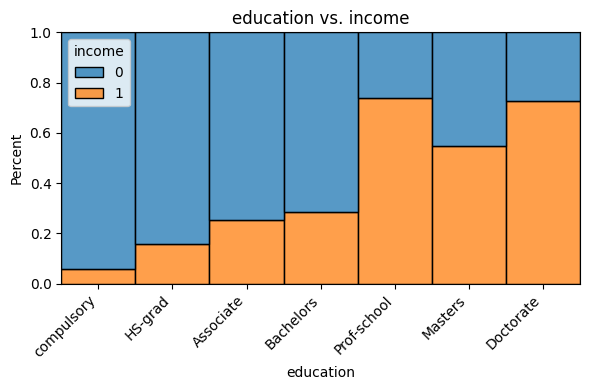

In [76]:
# Run the appropriate feature vs. target function (based on dtype)
plot_categorical_vs_target(df,x=feature, y=y);

- Feature vs. Target Observations:
  - Based on your business understanding, would you expect this feature to be a predictor of the target?
    - yes there is a relation higher education will leed  to more income , and lower educational people have lowest avarge of incomes.
    .
  - Does this feature appear to be a predictor of the target?
    - yes


___

### Example: {marital-status}


- marital-status:Married-civ-spouse corresponds to a civilian spouse while Married-AF-spouse is a spouse in the Armed Forces .
  
  - Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse

In [77]:
# # Confirming the dtype to select correct EDA function
feature = "marital-status"
df[feature].dtype

dtype('O')

<ipython-input-4-106c1043cd27>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


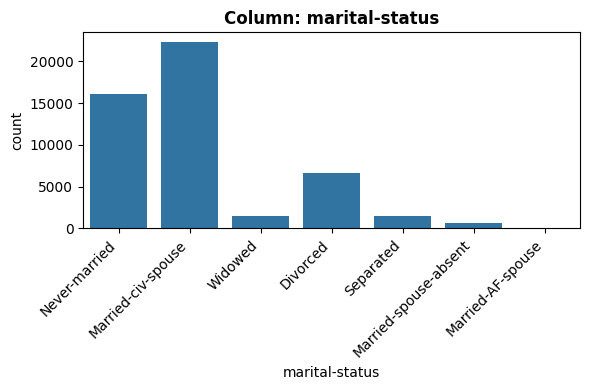

- NaN's Found: 0 (0.0%)
- Unique Values: 7
- Most common value: 'Married-civ-spouse' occurs 22366 times (45.84%)
- Not constant or quasi-constant.


In [78]:
# run the appropriate explore function (based on feature's dtype)
explore_categorical(df, feature);

**Feature Observations**

1. What type of feature is it? (Categorical (nominal), ordinal, numeric)
  - nominal

2. How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? if impute, with what?)
  - 0
  -

3. Is the feature constant or quasi-constant?
  - its not

4. What is the cardinality? Is it high?
  - close to be high cardinal with seven unique values
  -

5. Would we know this BEFORE the target is determined?
  - ...

6. Is there a business case/understanding reason to exclude based on our business case?
  - no



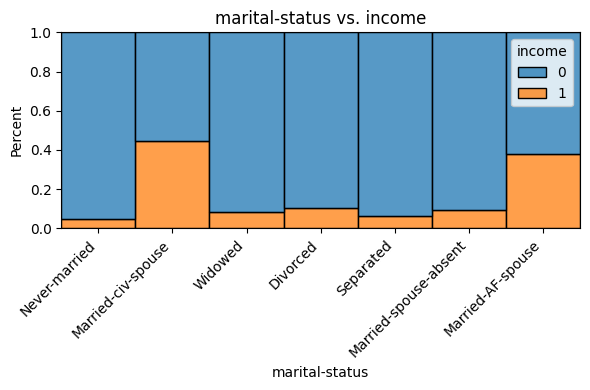

In [79]:
# Run the appropriate feature vs. target function (based on dtype)
plot_categorical_vs_target(df,x=feature, y=y);

- Feature vs. Target Observations:
  - Based on your business understanding, would you expect this feature to be a predictor of the target?
    - people who maried with civ , or af are with colse avarge of the income around 40% with more than 50k , and the rest of vales have almost same avarge of 80% with less than 50k income.
  - Does this feature appear to be a predictor of the target?
    - yes


___

### Example: {occupation}


- occupation: general type of occupation.
  - Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces
  

In [80]:
# # Confirming the dtype to select correct EDA function
feature = "occupation"
df[feature].dtype

dtype('O')

<ipython-input-4-106c1043cd27>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


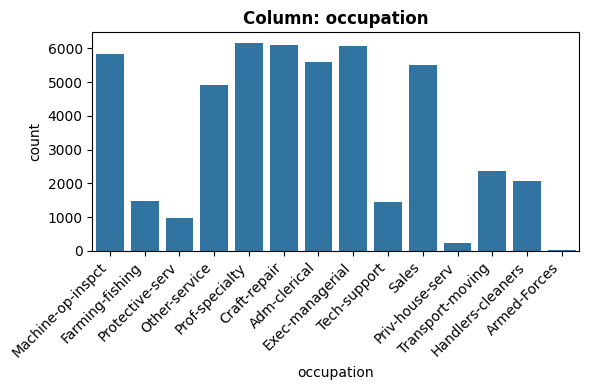

- NaN's Found: 0 (0.0%)
- Unique Values: 14
- Most common value: 'Prof-specialty' occurs 6165 times (12.64%)
- Not constant or quasi-constant.


In [81]:
# run the appropriate explore function (based on feature's dtype)
explore_categorical(df, feature);

**Feature Observations**

1. What type of feature is it? (Categorical (nominal), ordinal, numeric)
  - nominal

2. How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? if impute, with what?)
  - 0
  -

3. Is the feature constant or quasi-constant?
  - its not

4. What is the cardinality? Is it high?
  - yes
  -

5. Would we know this BEFORE the target is determined?
  - ...

6. Is there a business case/understanding reason to exclude based on our business case?
  -



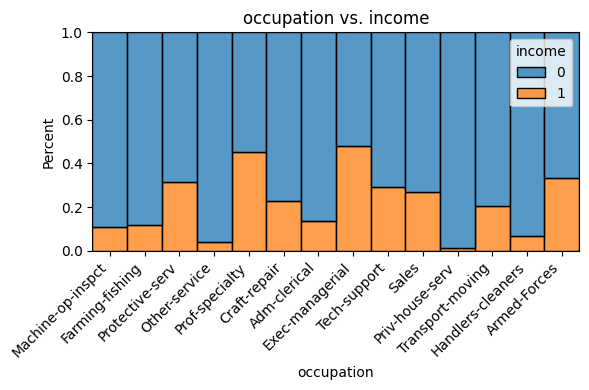

In [82]:
# Run the appropriate feature vs. target function (based on dtype)
plot_categorical_vs_target(df,x=feature, y=y);

- Feature vs. Target Observations:
  - Based on your business understanding, would you expect this feature to be a predictor of the target?
    - yes  there is a diffrences between the avarage of the income and the type of occupation
  - Does this feature appear to be a predictor of the target?
    - yes
    


___

### Example: {relationship}



- relationship:represents what this person is relative to others .
  - Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.
  

In [83]:
# # Confirming the dtype to select correct EDA function
feature = "relationship"
df[feature].dtype

dtype('O')

<ipython-input-4-106c1043cd27>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


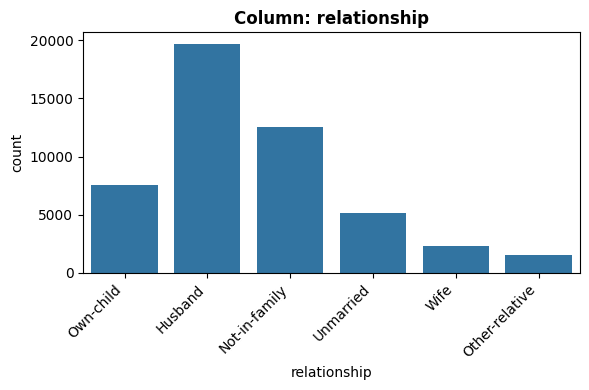

- NaN's Found: 0 (0.0%)
- Unique Values: 6
- Most common value: 'Husband' occurs 19703 times (40.38%)
- Not constant or quasi-constant.


In [84]:
# run the appropriate explore function (based on feature's dtype)
explore_categorical(df, feature);

**Feature Observations**

1. What type of feature is it? (Categorical (nominal), ordinal, numeric)
  - nominal

2. How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? if impute, with what?)
  - 0
  -

3. Is the feature constant or quasi-constant?
  - its not

4. What is the cardinality? Is it high?
  - no
  -

5. Would we know this BEFORE the target is determined?
  - ...

6. Is there a business case/understanding reason to exclude based on our business case?
  - no



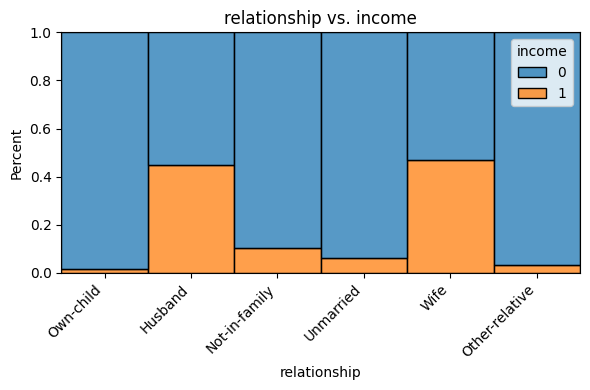

In [85]:
# Run the appropriate feature vs. target function (based on dtype)
plot_categorical_vs_target(df,x=feature,y=y);

- Feature vs. Target Observations:
  - Based on your business understanding, would you expect this feature to be a predictor of the target?
    - for the wife and husband values have almost same avarge  and pepole with one child have the lowest avarge of income with less than 50k.
  - Does this feature appear to be a predictor of the target?
    - yes


___

### Example: {race}

> Indented block



- race: .
 - White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black
  

In [86]:
# # Confirming the dtype to select correct EDA function
feature = "race"
df[feature].dtype

dtype('O')

<ipython-input-4-106c1043cd27>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


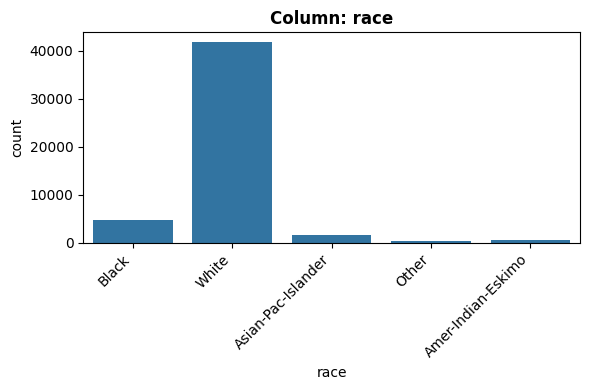

- NaN's Found: 0 (0.0%)
- Unique Values: 5
- Most common value: 'White' occurs 41714 times (85.5%)
- Not constant or quasi-constant.


In [87]:
# run the appropriate explore function (based on feature's dtype)
explore_categorical(df, feature);

**Feature Observations**

1. What type of feature is it? (Categorical (nominal), ordinal, numeric)
  - nominal

2. How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? if impute, with what?)
  - 0
  -

3. Is the feature constant or quasi-constant?
  - no

4. What is the cardinality? Is it high?
  - its not
  -

5. Would we know this BEFORE the target is determined?
  - ...

6. Is there a business case/understanding reason to exclude based on our business case?
  - yes its not related to target



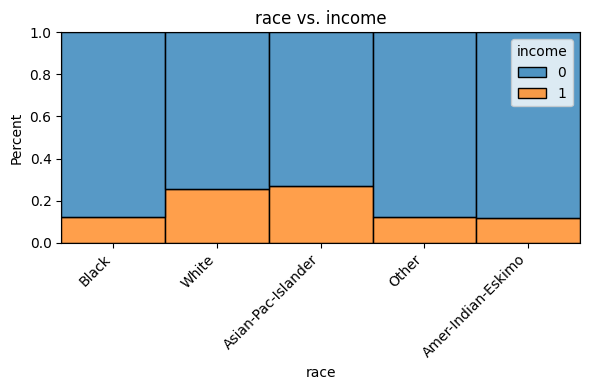

In [88]:
# Run the appropriate feature vs. target function (based on dtype)
plot_categorical_vs_target(df,x=feature, y=y);

- Feature vs. Target Observations:
  - Based on your business understanding, would you expect this feature to be a predictor of the target?
    - no
  - Does this feature appear to be a predictor of the target?
    - its not


___

### Example: {gender}

> Indented block



- gender: Male, female.
  
  

In [89]:
# # Confirming the dtype to select correct EDA function
feature = "gender"
df[feature].dtype

dtype('O')

<ipython-input-4-106c1043cd27>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


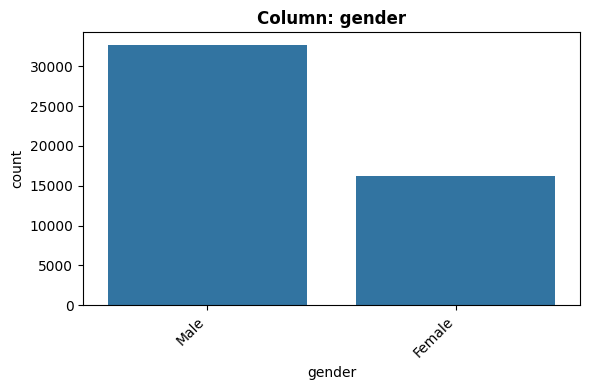

- NaN's Found: 0 (0.0%)
- Unique Values: 2
- Most common value: 'Male' occurs 32614 times (66.85%)
- Not constant or quasi-constant.


In [90]:
# run the appropriate explore function (based on feature's dtype)
explore_categorical(df, feature);

**Feature Observations**

1. What type of feature is it? (Categorical (nominal), ordinal, numeric)
  - nominal

2. How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? if impute, with what?)
  - 0
  -

3. Is the feature constant or quasi-constant?
  - its not

4. What is the cardinality? Is it high?
  - its not
  -

5. Would we know this BEFORE the target is determined?
  - ...

6. Is there a business case/understanding reason to exclude based on our business case?
  - no



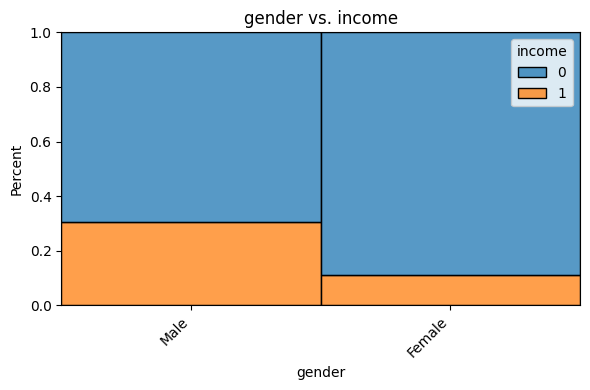

In [91]:
# Run the appropriate feature vs. target function (based on dtype)
plot_categorical_vs_target(df,x=feature,y=y);

- Feature vs. Target Observations:
  - Based on your business understanding, would you expect this feature to be a predictor of the target?
    - males have higher avarge with income more than 50k than femals

  - Does this feature appear to be a predictor of the target?
    -yes


___

### Example: {capital-gain}

> Indented block



- capital-gain: .
  
  

In [92]:
# # Confirming the dtype to select correct EDA function
feature = "capital-gain"
df[feature].dtype

dtype('int64')

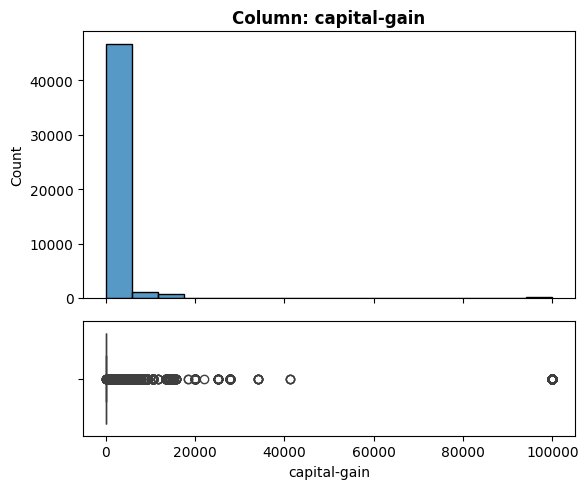

- NaN's Found: 0 (0.0%)
- Unique Values: 123
- Most common value: '0' occurs 44755 times (91.73%)
- Not constant or quasi-constant.


In [93]:
# run the appropriate explore function (based on feature's dtype)
explore_numeric(df, feature);

**Feature Observations**

1. What type of feature is it? (Categorical (nominal), ordinal, numeric)
  - numeric

2. How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? if impute, with what?)
  - 0
  -

3. Is the feature constant or quasi-constant?
  - its not

4. What is the cardinality? Is it high?
  - numeric
  -

5. Would we know this BEFORE the target is determined?
  - ...

6. Is there a business case/understanding reason to exclude based on our business case?
  - no



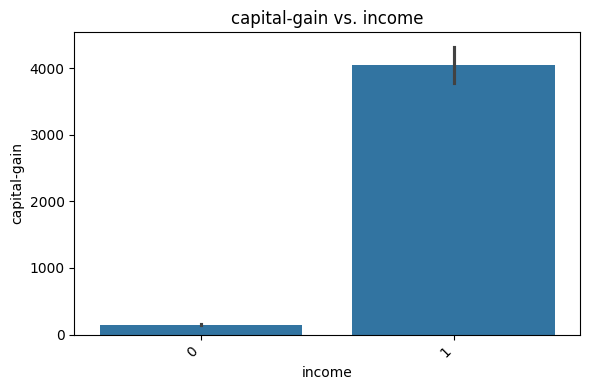

In [94]:
# Run the appropriate feature vs. target function (based on dtype)
plot_numeric_vs_target(df,x=feature, y=y);

- Feature vs. Target Observations:
  - Based on your business understanding, would you expect this feature to be a predictor of the target?
    - the avarage for people with income more than 50k is around 4000 caoital-gain
  - Does this feature appear to be a predictor of the target?
    - yes


___

### Example: {capital-loss}

> Indented block



- capital-loss: .
  
  

In [95]:
# # Confirming the dtype to select correct EDA function
feature = "capital-loss"
df[feature].dtype

dtype('int64')

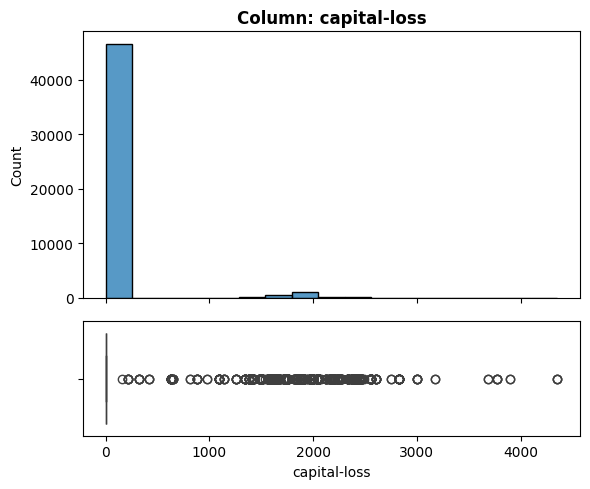

- NaN's Found: 0 (0.0%)
- Unique Values: 99
- Most common value: '0' occurs 46508 times (95.32%)
- Not constant or quasi-constant.


In [96]:
# run the appropriate explore function (based on feature's dtype)
explore_numeric(df, feature);

**Feature Observations**

1. What type of feature is it? (Categorical (nominal), ordinal, numeric)
  - numeric

2. How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? if impute, with what?)
  - 0
  -

3. Is the feature constant or quasi-constant?
  - not

4. What is the cardinality? Is it high?
  - numeric
  -

5. Would we know this BEFORE the target is determined?
  - ...

6. Is there a business case/understanding reason to exclude based on our business case?
  - n0



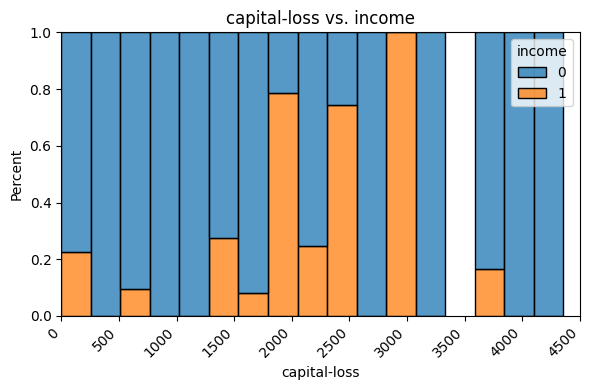

In [97]:
# Run the appropriate feature vs. target function (based on dtype)
plot_categorical_vs_target(df,x=feature, y=y);

- Feature vs. Target Observations:
  - Based on your business understanding, would you expect this feature to be a predictor of the target?
     - the averge of income higher than 50k happen more with avarage between 2000-3000 capital-loss values , and after that with higher capital-loss and lower capital-loss the income avarge is tend to be more with less avarage than 50 k
  - Does this feature appear to be a predictor of the target?
    - yes


___

### Example: {hours-per-week}

> Indented block



- hours-per-week: .
  
  

In [98]:
# # Confirming the dtype to select correct EDA function
feature = "hours-per-week"
df[feature].dtype

dtype('int64')

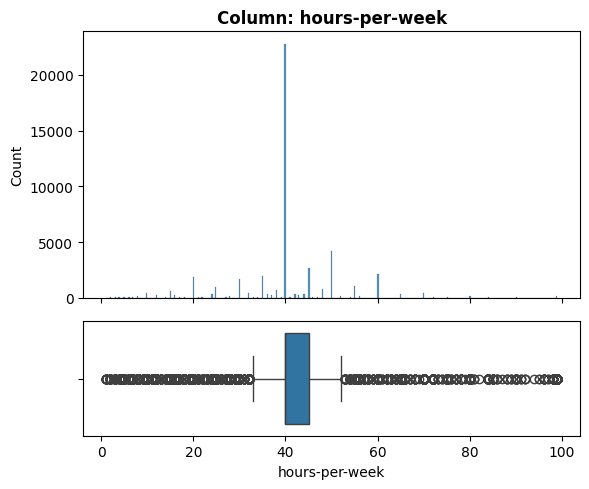

- NaN's Found: 0 (0.0%)
- Unique Values: 96
- Most common value: '40' occurs 22773 times (46.68%)
- Not constant or quasi-constant.


In [99]:
# run the appropriate explore function (based on feature's dtype)
explore_numeric(df, feature);

**Feature Observations**

1. What type of feature is it? (Categorical (nominal), ordinal, numeric)
  - numeric

2. How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? if impute, with what?)
  - 0
  -

3. Is the feature constant or quasi-constant?
  - its not

4. What is the cardinality? Is it high?
  - numeric
  -

5. Would we know this BEFORE the target is determined?
  - ...

6. Is there a business case/understanding reason to exclude based on our business case?
  - no



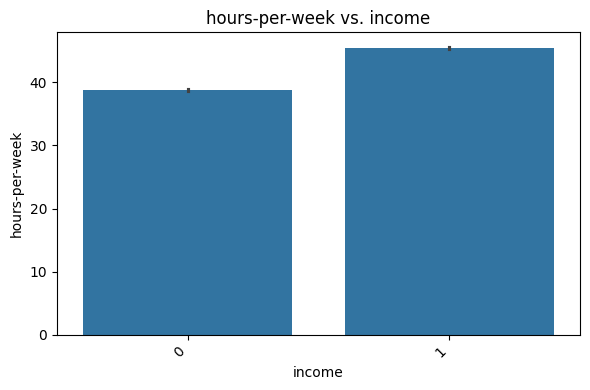

In [100]:
# Run the appropriate feature vs. target function (based on dtype)
plot_numeric_vs_target(df,x=feature, y=y);

- Feature vs. Target Observations:
  - Based on your business understanding, would you expect this feature to be a predictor of the target?
    - pepole who works for more than 40 hours per week tend to have income higher than 50k than people work for less than 40 hours per week. yes it would be
  - Does this feature appear to be a predictor of the target?
    - yes


___

### Example: {native-country}

> Indented block



- native-country: country of origin .
  
  

In [101]:
# # Confirming the dtype to select correct EDA function
feature = "native-country"
df[feature].dtype

dtype('O')

<ipython-input-4-106c1043cd27>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


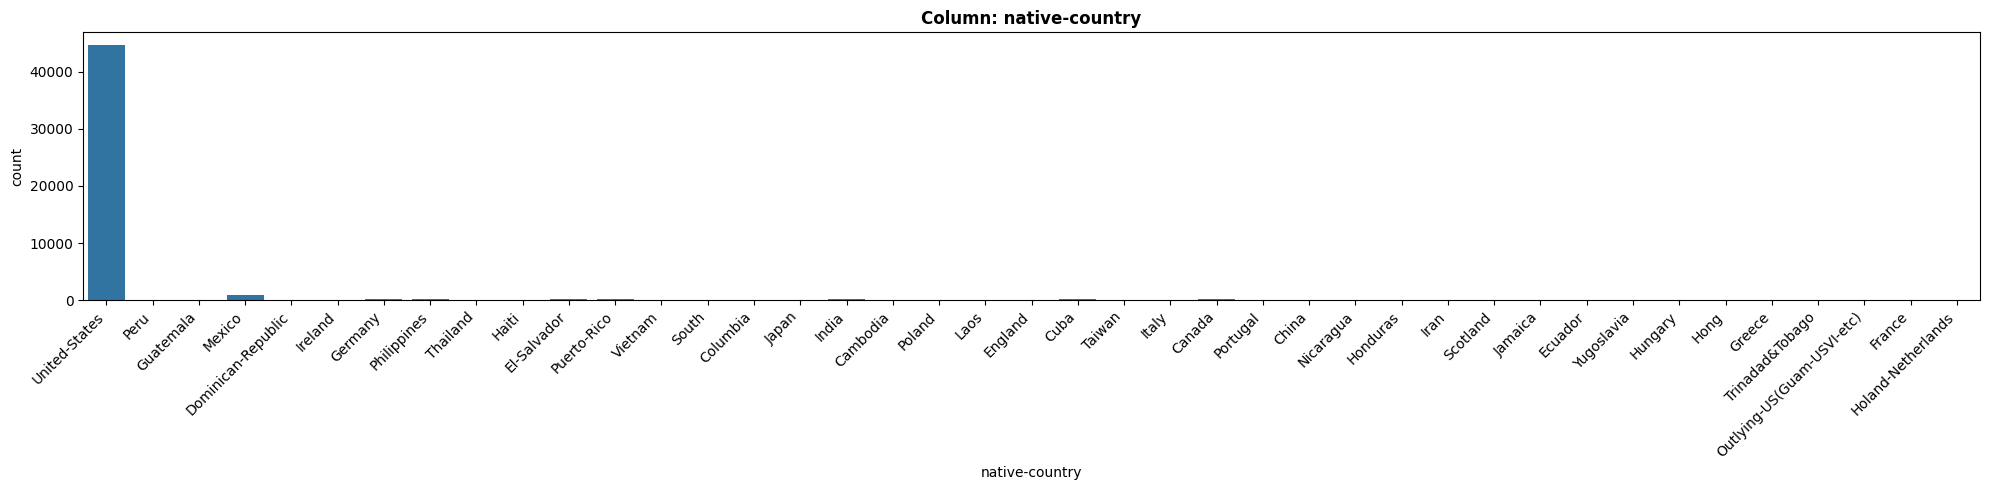

- NaN's Found: 0 (0.0%)
- Unique Values: 41
- Most common value: 'United-States' occurs 44648 times (91.51%)
- Not constant or quasi-constant.


In [102]:
# run the appropriate explore function (based on feature's dtype)
explore_categorical(df, feature, figsize=(20,5));

**Feature Observations**

1. What type of feature is it? (Categorical (nominal), ordinal, numeric)
  - nominal

2. How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? if impute, with what?)
  - 0
  -

3. Is the feature constant or quasi-constant?
  - its not

4. What is the cardinality? Is it high?
  - yes
  -

5. Would we know this BEFORE the target is determined?
  - ...

6. Is there a business case/understanding reason to exclude based on our business case?
  - no



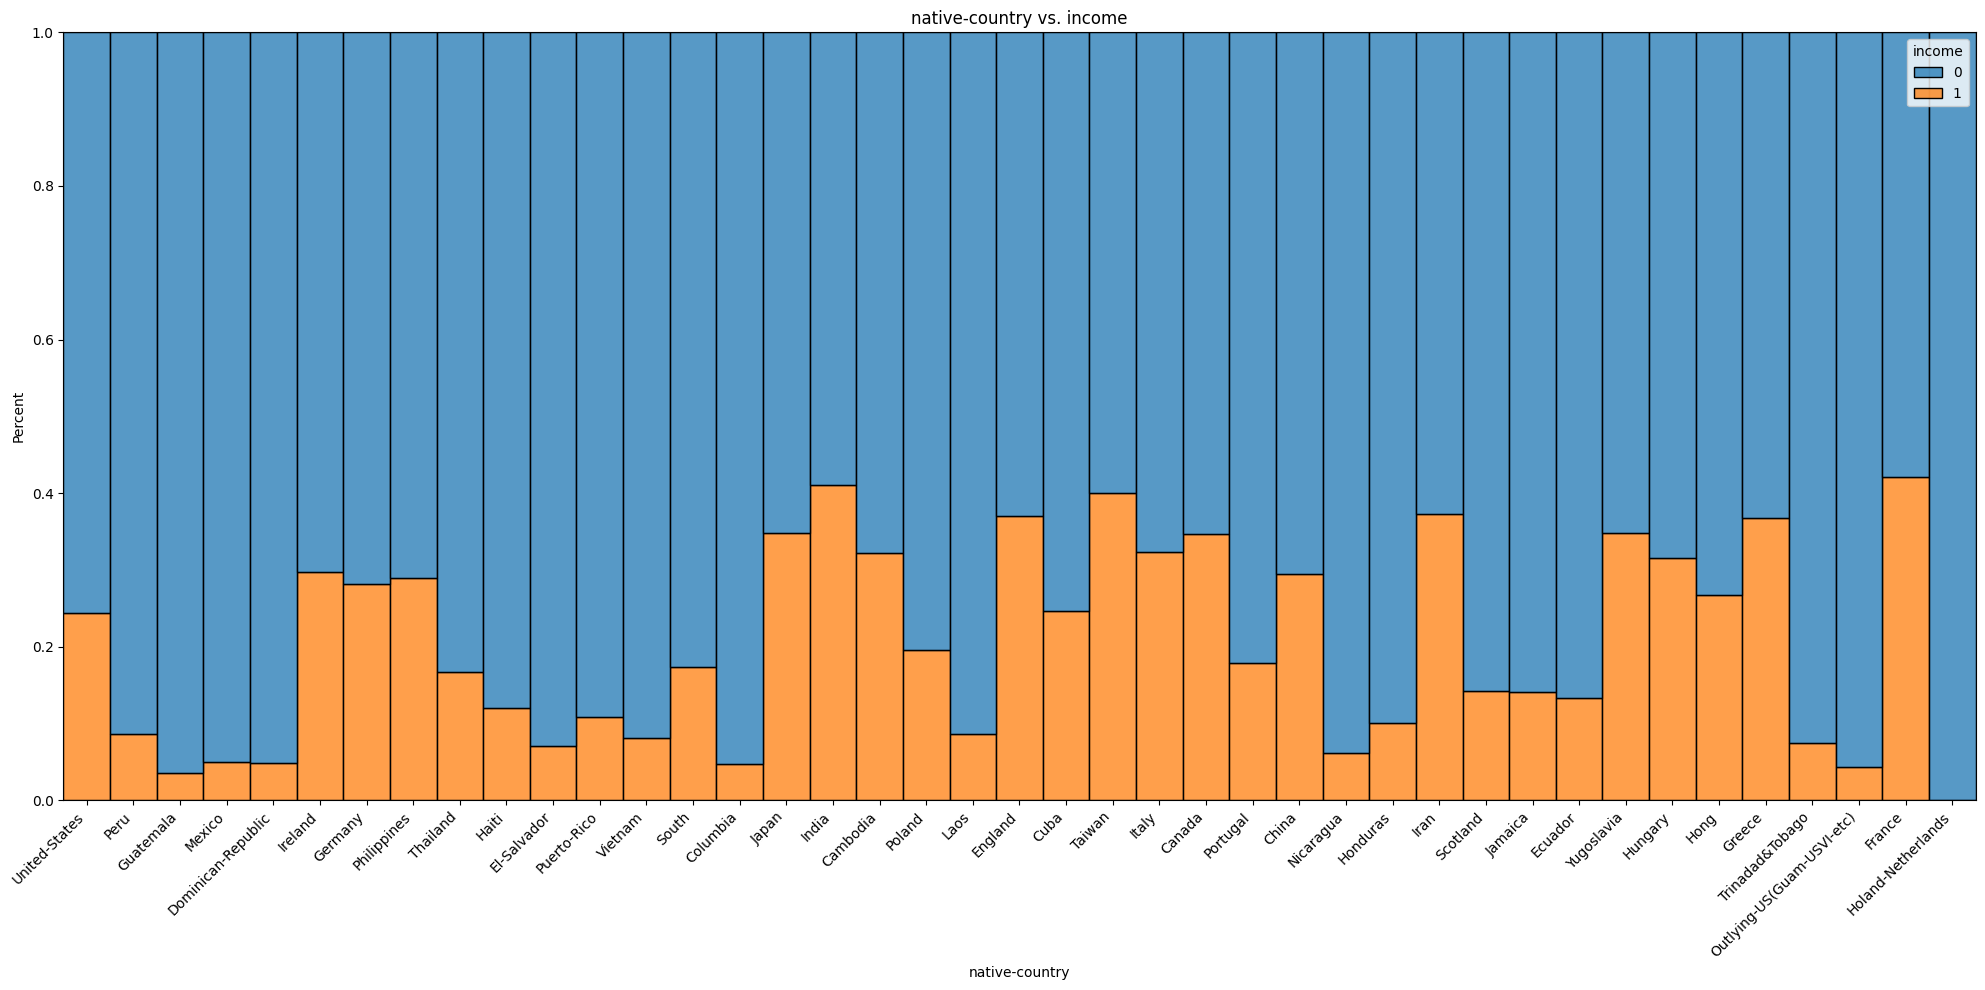

In [103]:
# Run the appropriate feature vs. target function (based on dtype)
plot_categorical_vs_target(df,x=feature,y=y, figsize=(20,10));

- Feature vs. Target Observations:
  - Based on your business understanding, would you expect this feature to be a predictor of the target?
    - france and then india have the higher avarge of more than 50k income and in holand all people have income less than 50k.
  - Does this feature appear to be a predictor of the target?
    -


___

# Preprocessing

In [28]:
# define target and features matrix
y = df['income']
X = df.drop(columns=['income', 'fnlwgt', 'native-country'])
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [29]:
X_train['education'].value_counts()

education
Bachelors      14147
HS-grad        11822
compulsory      4796
Associate       2745
Masters         1989
Prof-school      640
Doctorate        453
Name: count, dtype: int64

In [30]:
# preprocessing for numeric columns
# define veriable
num_cols = X_train.select_dtypes('number').drop(columns='educational-num').columns
print(f'Numeric Columns: {num_cols}')
# scaling numeric columns
num_scaler = StandardScaler()
# numeric pipeline
num_pipe = make_pipeline(num_scaler)
# numeric tuple
num_tuple = ('Numeric', num_pipe, num_cols)
num_pipe

Numeric Columns: Index(['age', 'capital-gain', 'capital-loss', 'hours-per-week'], dtype='object')


Pipeline(steps=[('standardscaler', StandardScaler())])

In [36]:
# preprocessing for categorical ( ordinal )columns
ord_cols =['education', 'educational-num']
print('Ordinal Columns:', ord_cols)
# the order od ordinal values
edu_order = ['compulsory', 'HS-grad', 'Prof-school', 'Associate', 'Bachelors', 'Masters', 'Doctorate']
edu_num_order = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
# ordinal encoder
ord_encoder = OrdinalEncoder(categories=[edu_order, edu_num_order])
# scaling ordinal coulumn
ord_scaler = StandardScaler()
# ordinal pipe
ord_pipe = make_pipeline(ord_encoder, ord_scaler)
# tupel for transformation
ord_tuple = ('Ordinal Columns', ord_pipe, ord_cols)
ord_pipe

Ordinal Columns: ['education', 'educational-num']


Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(categories=[['compulsory', 'HS-grad',
                                             'Prof-school', 'Associate',
                                             'Bachelors', 'Masters',
                                             'Doctorate'],
                                            [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                             12, 13, 14, 15, 16]])),
                ('standardscaler', StandardScaler())])

In [37]:
# preprocessin nominal columns
ohe_cols = X_train.select_dtypes('object').drop(columns='education').columns
print('Nominal Columns:', ohe_cols)
# one hot encoding for nominal columns
ohe_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
# nominal pipe
ohe_pipe = make_pipeline(ohe_encoder)
# nominal tuple for columntransform
ohe_tuple = ('Nominal Columns', ohe_pipe, ohe_cols)
ohe_pipe

Nominal Columns: Index(['workclass', 'marital-status', 'occupation', 'relationship', 'race',
       'gender'],
      dtype='object')


Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

In [38]:
# instantiate the column transformer
preprocessor = ColumnTransformer([num_tuple, ohe_tuple,ord_tuple], verbose_feature_names_out=False)
# fit preprocessor on training data
preprocessor.fit(X_train)

ColumnTransformer(transformers=[('Numeric',
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler())]),
                                 Index(['age', 'capital-gain', 'capital-loss', 'hours-per-week'], dtype='object')),
                                ('Nominal Columns',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 Index(['workclass', 'marital-status', 'occupation', 'relationship', 'race',
       'gender'],
      dtype='object')),
                                ('Ordinal Columns',
                                 Pipeline(steps=[('ordinalencoder',
                                                  OrdinalEncoder(categories=[['compulsory',
                                                                              'HS-grad',
                                                                              'Prof-school',
                                                                              'Associate',
                                                                              'Bachelors',
                                                                              'Masters',
                                                                              'Doctorate'],
                                                                             [1,
                                                                              2,
                                                                              3,
                                                                              4,
                                                                              5,
                                                                              6,
                                                                              7,
                                                                              8,
                                                                              9,
                                                                              10,
                                                                              11,
                                                                              12,
                                                                              13,
                                                                              14,
                                                                              15,
                                                                              16]])),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['education', 'educational-num'])],
                  verbose_feature_names_out=False)

In [39]:
# transform train data
X_train_tf = pd.DataFrame(preprocessor.transform(X_train))
# transform test data
X_test_tf =pd.DataFrame(preprocessor.transform(X_test))

# Modeling

In [40]:
# check the target balance
y.value_counts(1)

income
0    0.760586
1    0.239414
Name: proportion, dtype: float64

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      0.93      0.91     27841
           1       0.73      0.60      0.66      8751

    accuracy                           0.85     36592
   macro avg       0.81      0.77      0.78     36592
weighted avg       0.85      0.85      0.85     36592



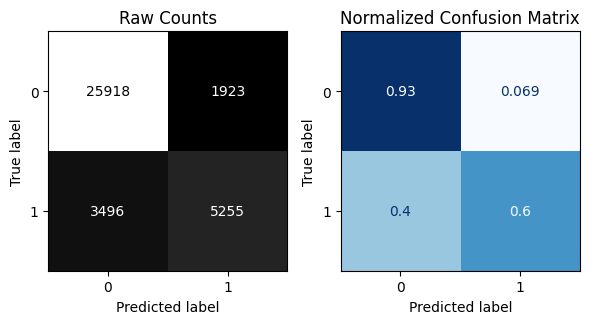


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      0.94      0.91      9268
           1       0.74      0.58      0.65      2930

    accuracy                           0.85     12198
   macro avg       0.81      0.76      0.78     12198
weighted avg       0.84      0.85      0.84     12198



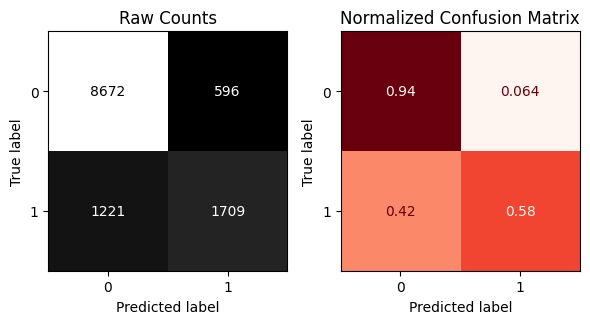

In [41]:
# instantiat a Logistic Regression model
logreg = LogisticRegression(max_iter=500, random_state=42)
# fit thhe model on training data
logreg.fit(X_train_tf, y_train)
# evaluate model
evaluate_classification(logreg, X_train_tf, y_train, X_test_tf, y_test)

- the data is imbalnce and the macro avg of the model is .78 so the model was able to predict 78 % of our target.

In [42]:
# extract top ten features by permutation importance
r = permutation_importance(logreg, X_test_tf, y_test, n_repeats=5, random_state=42)
permutation_importance = pd.Series(r['importances_mean'], index=X_test_tf.columns, name='permutation importance')
permutation_importance = permutation_importance.sort_values(ascending=False)
permutation_importance


marital-status_Married-civ-spouse       3.272668e-02
capital-gain                            3.202164e-02
educational-num                         2.772586e-02
marital-status_Never-married            8.460403e-03
occupation_Exec-managerial              7.722577e-03
capital-loss                            4.836859e-03
relationship_Wife                       4.640105e-03
age                                     4.394163e-03
hours-per-week                          4.213806e-03
occupation_Prof-specialty               3.623545e-03
occupation_Tech-support                 1.934743e-03
relationship_Own-child                  1.590425e-03
occupation_Other-service                1.262502e-03
marital-status_Divorced                 1.180521e-03
workclass_Self-emp-not-inc              1.180521e-03
occupation_Farming-fishing              8.198065e-04
marital-status_Separated                8.034104e-04
occupation_Handlers-cleaners            8.034104e-04
occupation_Protective-serv              6.8863

[Text(0.5, 0, 'Permutation Importance'),
 Text(0, 0.5, 'Feature Names'),
 Text(0.5, 1.0, 'Top 10 Most Permutation Important Features ')]

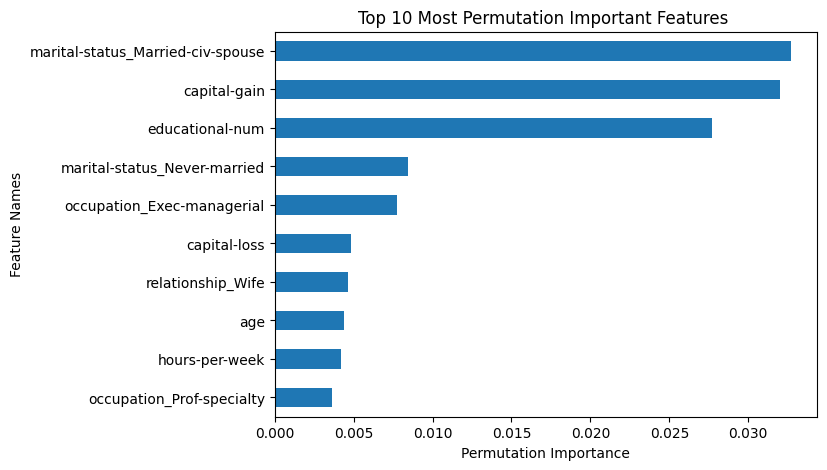

In [43]:
# visualize top ten features by permutation importance
ax =permutation_importance.sort_values().tail(10).plot(kind='barh', figsize=(7,5))
ax.set(xlabel='Permutation Importance', ylabel='Feature Names', title='Top 10 Most Permutation Important Features ')

- Do these features make sense based on the business case?
  -yes they do , from the plots above i got same observation and for these features and there was a clear  veriance of target avarge between them and other values in orginal feature

<ipython-input-59-291933388cba>:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


[Text(0, 0, 'Never-married'),
 Text(1, 0, 'Married-civ-spouse'),
 Text(2, 0, 'Widowed'),
 Text(3, 0, 'Divorced'),
 Text(4, 0, 'Separated'),
 Text(5, 0, 'Married-spouse-absent'),
 Text(6, 0, 'Married-AF-spouse')]

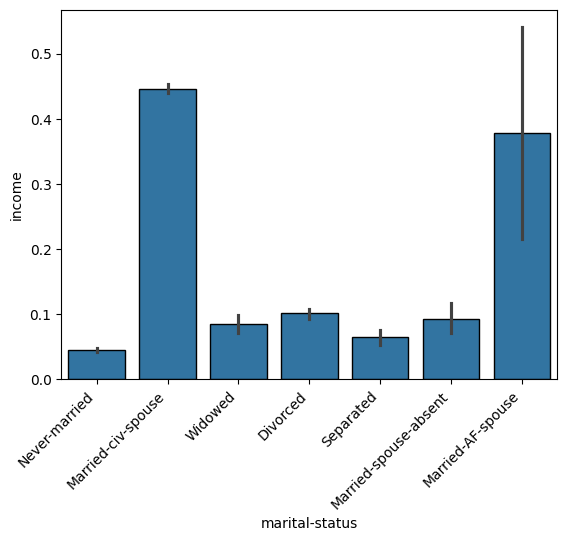

In [59]:
# visualse the relashion of marital-status vs income
ax = sns.barplot(data=df, x='marital-status',y='income',edgecolor='black',
            linewidth=1);
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

- as you see from the plot above the higher bar means those pepole relay on same statue have heighr tendency to have a higher income (more than 50k) , it seems the life stability for peapole make imporve their life and their foucs to get more income.

In [ ]:
# visualize educational-num with the target
ax = sns.barplot(data=df, x='educational-num',y='income',edgecolor='black',
            linewidth=1);
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')